<a href="https://colab.research.google.com/github/thieuhy/Food-Insecurity-Prediction/blob/main/GWG_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load dataset into a dataframe
insecurity = pd.read_excel("2025-food-environment-atlas-data.xlsx", sheet_name="INSECURITY", skiprows=1)

# Load first 10 of the dataset
insecurity.head(10)

,FIPS,State,County,FOODINSEC_18_20,FOODINSEC_21_23,CH_FOODINSEC_20_23,VLFOODSEC_18_20,VLFOODSEC_21_23,CH_VLFOODSEC_20_23
0,1001,AL,Autauga,14.0,11.5,-2.5,5.2,4.4,-0.8
1,1003,AL,Baldwin,14.0,11.5,-2.5,5.2,4.4,-0.8
2,1005,AL,Barbour,14.0,11.5,-2.5,5.2,4.4,-0.8
3,1007,AL,Bibb,14.0,11.5,-2.5,5.2,4.4,-0.8
4,1009,AL,Blount,14.0,11.5,-2.5,5.2,4.4,-0.8
5,1011,AL,Bullock,14.0,11.5,-2.5,5.2,4.4,-0.8
6,1013,AL,Butler,14.0,11.5,-2.5,5.2,4.4,-0.8
7,1015,AL,Calhoun,14.0,11.5,-2.5,5.2,4.4,-0.8
8,1017,AL,Chambers,14.0,11.5,-2.5,5.2,4.4,-0.8
9,1019,AL,Cherokee,14.0,11.5,-2.5,5.2,4.4,-0.8


# Basic Exploration

In [ ]:
# Display dataset shape and general info
print("Dataset Shape:", insecurity.shape)
print("\n--- Dataset Information ---")
insecurity.info()

# Show data types of each column
print("\n--- Data Types ---")
print(insecurity.dtypes)

# Check for missing values
print("\n--- Missing Values ---")
print(insecurity.isna().sum())

# Get descriptive statistics for numeric columns
print("\n--- Descriptive Statistics ---")
print(insecurity.describe().round(2))

# Quick preview of first few rows
print("\n--- Sample Rows ---")
print(insecurity.head())


Dataset Shape: (3152, 9)

--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3152 entries, 0 to 3151
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FIPS                3152 non-null   int64  
 1   State               3152 non-null   object 
 2   County              3152 non-null   object 
 3   FOODINSEC_18_20     3152 non-null   float64
 4   FOODINSEC_21_23     3152 non-null   float64
 5   CH_FOODINSEC_20_23  3152 non-null   float64
 6   VLFOODSEC_18_20     3152 non-null   float64
 7   VLFOODSEC_21_23     3152 non-null   float64
 8   CH_VLFOODSEC_20_23  3152 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 221.8+ KB

--- Data Types ---
FIPS                    int64
State                  object
County                 object
FOODINSEC_18_20       float64
FOODINSEC_21_23       float64
CH_FOODINSEC_20_23    float64
VLFOODSEC_18_20       float64
VLFOODS

In [ ]:
# Rename columns for clarity
insecurity.columns = [
    "FIPS", "State", "County",
    "FoodInsecurityRate_2018_2020", "FoodInsecurityRate_2021_2023", "ChangeInFoodInsecurity_2020_2023",
    "VeryLowFoodSecurityRate_2018_2020", "VeryLowFoodSecurityRate_2021_2023", "ChangeInVeryLowFoodSecurity_2020_2023"
]

# Data Exploration (EDA)

In [ ]:
# Data Cleaning
columns_to_clean = [
    "FoodInsecurityRate_2018_2020", "FoodInsecurityRate_2021_2023",
    "ChangeInFoodInsecurity_2020_2023",
    "VeryLowFoodSecurityRate_2018_2020", "VeryLowFoodSecurityRate_2021_2023",
    "ChangeInVeryLowFoodSecurity_2020_2023"
]

# Replace sentinel values (-8888) with NaN
insecurity[columns_to_clean] = insecurity[columns_to_clean].replace(-8888, np.nan)

# Impute missing values with median
insecurity[columns_to_clean] = insecurity[columns_to_clean].apply(lambda col: col.fillna(col.median()))

# Confirm data is clean
print("Missing values after cleaning:")
print(insecurity[columns_to_clean].isna().sum())

Missing values after cleaning:
FoodInsecurityRate_2018_2020             0
FoodInsecurityRate_2021_2023             0
ChangeInFoodInsecurity_2020_2023         0
VeryLowFoodSecurityRate_2018_2020        0
VeryLowFoodSecurityRate_2021_2023        0
ChangeInVeryLowFoodSecurity_2020_2023    0
dtype: int64



Total missing values after replacing -8888 with NaN:
FoodInsecurityRate_2018_2020             0
FoodInsecurityRate_2021_2023             0
ChangeInFoodInsecurity_2020_2023         0
VeryLowFoodSecurityRate_2018_2020        0
VeryLowFoodSecurityRate_2021_2023        0
ChangeInVeryLowFoodSecurity_2020_2023    0
dtype: int64


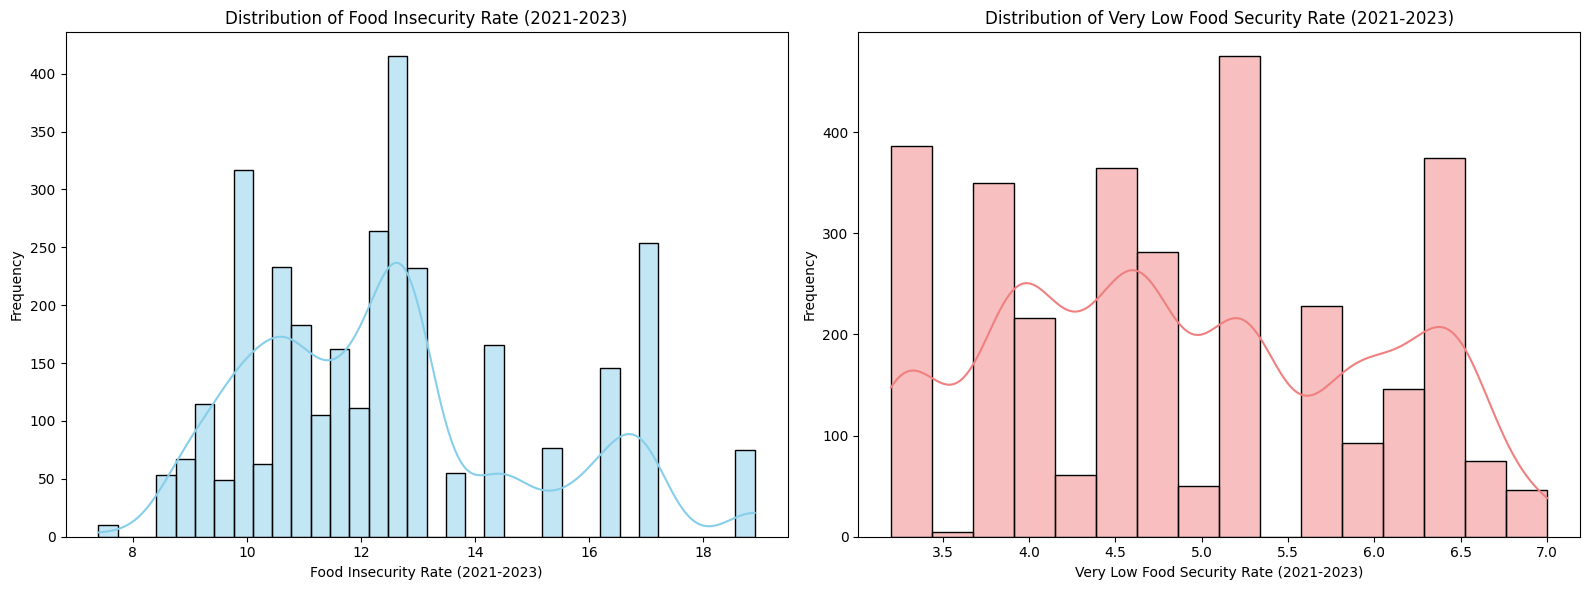

In [ ]:
columns_to_clean = [
    "FoodInsecurityRate_2018_2020", "FoodInsecurityRate_2021_2023", "ChangeInFoodInsecurity_2020_2023",
    "VeryLowFoodSecurityRate_2018_2020", "VeryLowFoodSecurityRate_2021_2023", "ChangeInVeryLowFoodSecurity_2020_2023"
]

print("\nTotal missing values after replacing -8888 with NaN:")
print(insecurity[columns_to_clean].isnull().sum())

# Create histograms for specified columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=insecurity, x='FoodInsecurityRate_2021_2023', kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Food Insecurity Rate (2021-2023)')
axes[0].set_xlabel('Food Insecurity Rate (2021-2023)')
axes[0].set_ylabel('Frequency')

sns.histplot(data=insecurity, x='VeryLowFoodSecurityRate_2021_2023', kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution of Very Low Food Security Rate (2021-2023)')
axes[1].set_xlabel('Very Low Food Security Rate (2021-2023)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

/tmp/ipython-input-1286662280.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-1286662280.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


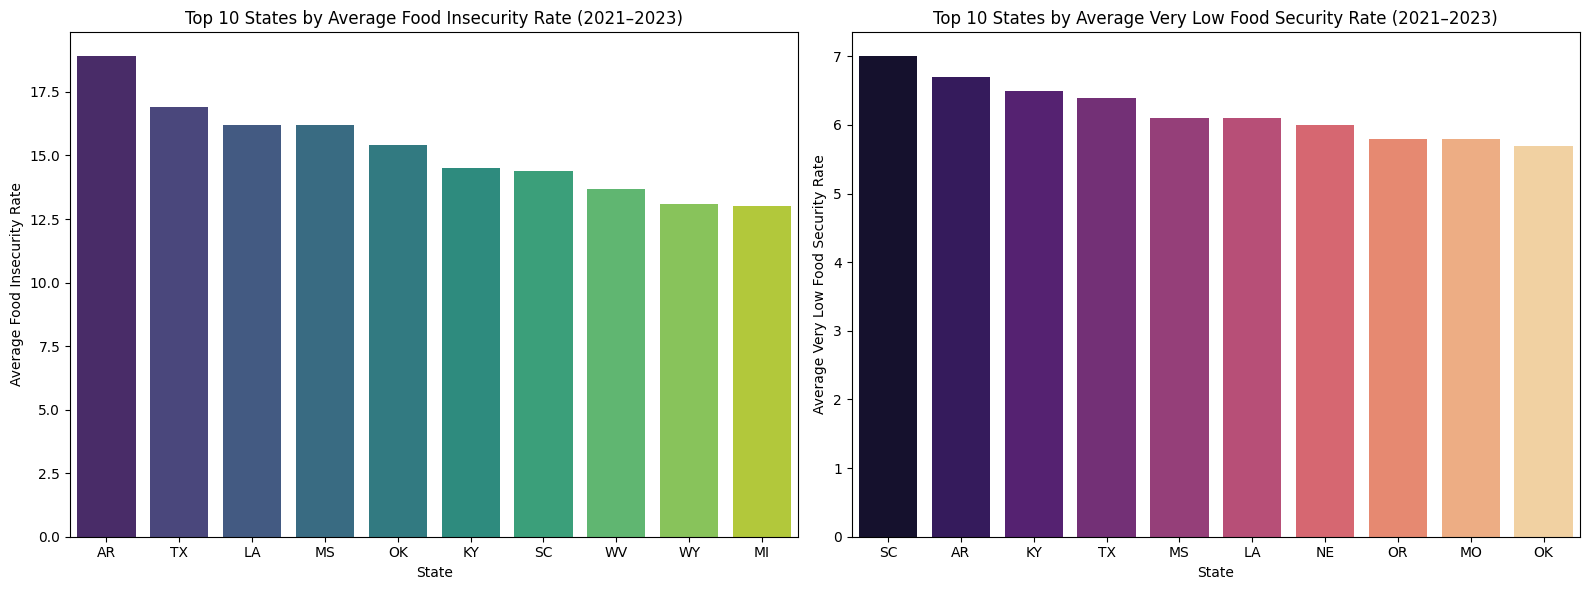

In [ ]:
# ===== Top 10 States by Food Insecurity & Very Low Food Security Rates (2021–2023) =====
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Food Insecurity
sns.barplot(
    x='State',
    y='FoodInsecurityRate_2021_2023',
    data=top_10_foodinsec,
    palette='viridis',
    ax=axes[0],
    legend=False
)
axes[0].set_title('Top 10 States by Average Food Insecurity Rate (2021–2023)')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Average Food Insecurity Rate')

# Right: Very Low Food Security
sns.barplot(
    x='State',
    y='VeryLowFoodSecurityRate_2021_2023',
    data=top_10_vlfoodsec,
    palette='magma',
    ax=axes[1],
    legend=False
)
axes[1].set_title('Top 10 States by Average Very Low Food Security Rate (2021–2023)')
axes[1].set_xlabel('State')
axes[1].set_ylabel('Average Very Low Food Security Rate')

plt.tight_layout()
plt.show()


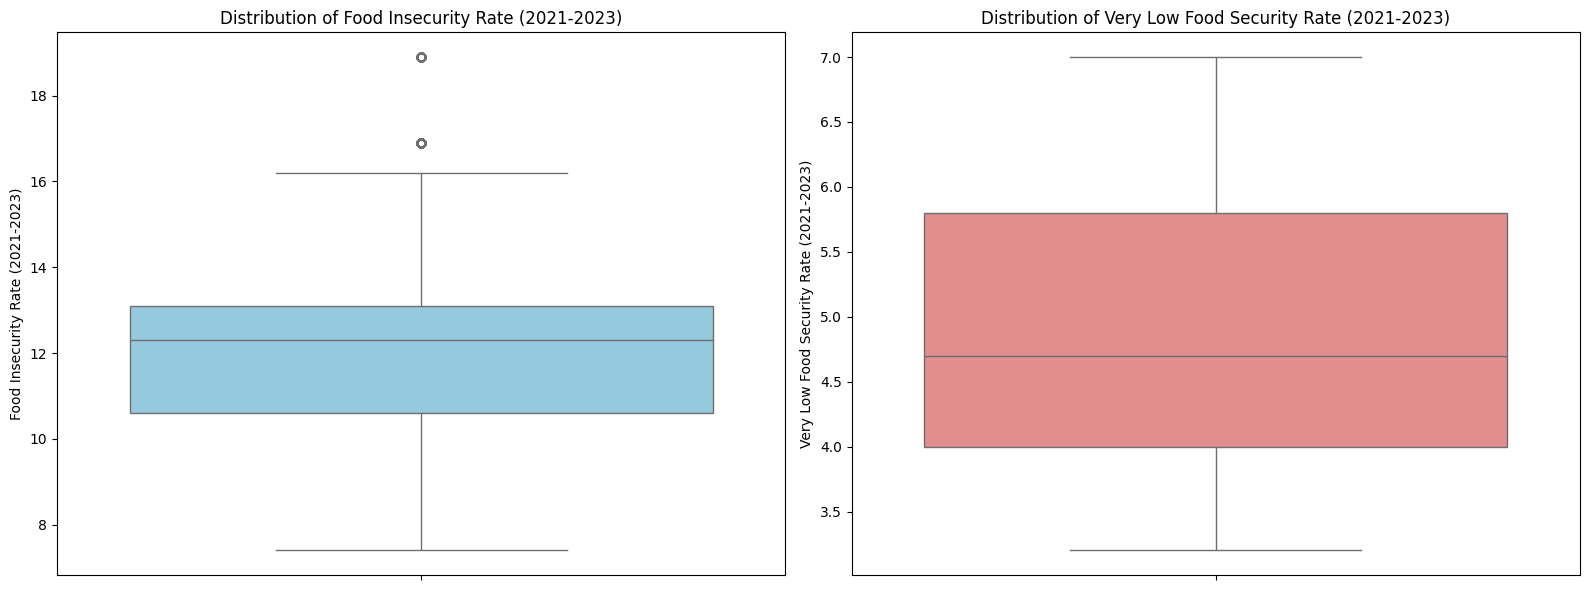

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=insecurity, y='FoodInsecurityRate_2021_2023', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Food Insecurity Rate (2021-2023)')
axes[0].set_ylabel('Food Insecurity Rate (2021-2023)')

sns.boxplot(data=insecurity, y='VeryLowFoodSecurityRate_2021_2023', ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution of Very Low Food Security Rate (2021-2023)')
axes[1].set_ylabel('Very Low Food Security Rate (2021-2023)')

plt.tight_layout()
plt.show()

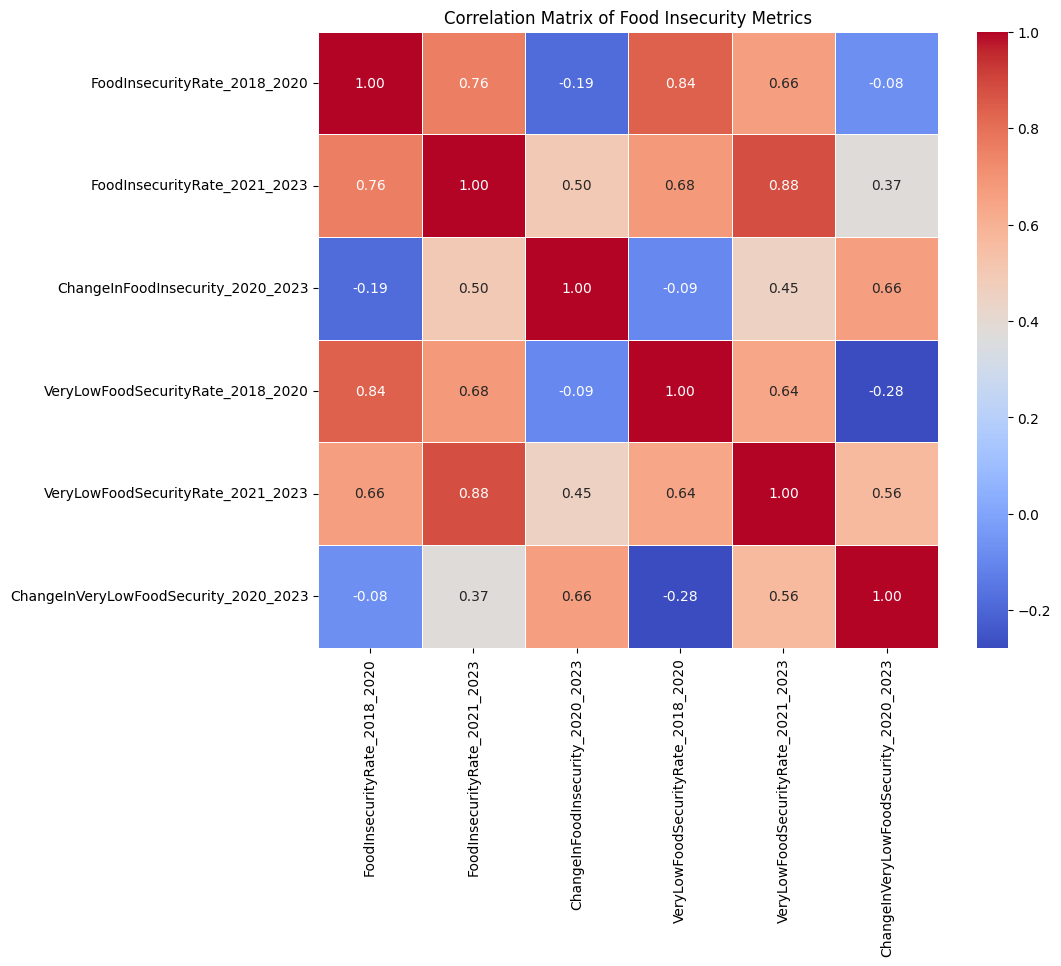

In [ ]:
food_insecurity_cols = [
    "FoodInsecurityRate_2018_2020", "FoodInsecurityRate_2021_2023", "ChangeInFoodInsecurity_2020_2023",
    "VeryLowFoodSecurityRate_2018_2020", "VeryLowFoodSecurityRate_2021_2023", "ChangeInVeryLowFoodSecurity_2020_2023"
]

correlation_matrix = insecurity[food_insecurity_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Food Insecurity Metrics')
plt.show()

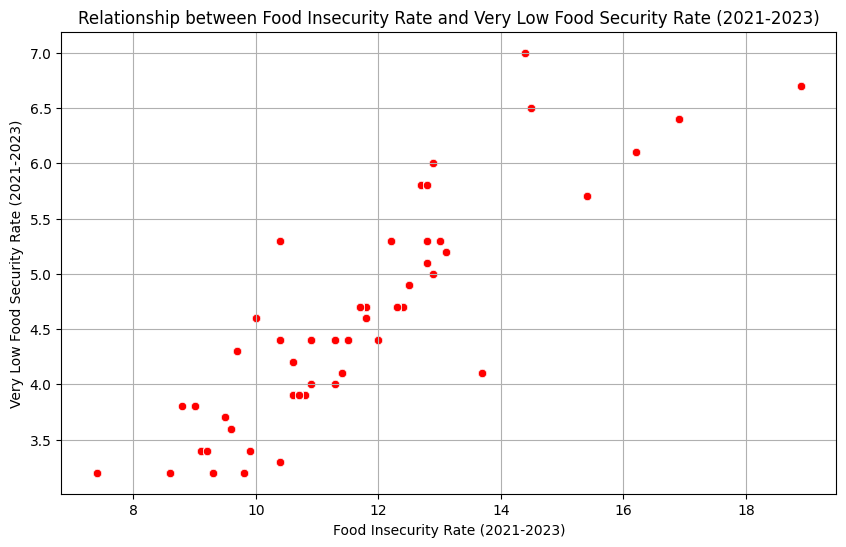

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=insecurity, x='FoodInsecurityRate_2021_2023', y='VeryLowFoodSecurityRate_2021_2023', color='red')
plt.title('Relationship between Food Insecurity Rate and Very Low Food Security Rate (2021-2023)')
plt.xlabel('Food Insecurity Rate (2021-2023)')
plt.ylabel('Very Low Food Security Rate (2021-2023)')
plt.grid(True)
plt.show()

# Machine Learning Setup

In [ ]:
# Target variable
y = insecurity["FoodInsecurityRate_2021_2023"]

# Feature matrix
X = insecurity[[
    "FoodInsecurityRate_2018_2020",
    "VeryLowFoodSecurityRate_2018_2020",
    "ChangeInFoodInsecurity_2020_2023",
    "ChangeInVeryLowFoodSecurity_2020_2023",
    "State"
]].copy()

# One-hot encode State
X = pd.get_dummies(X, columns=["State"], drop_first=True)


## Machine Learning Model: Training and Evaluation


In [ ]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Final Model
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

#Evaluate Model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.3f},  MAE: {mae:.3f},  RMSE: {rmse:.3f}")

R²: 1.000,  MAE: 0.000,  RMSE: 0.000


## Evaluate Model Interpretability



/tmp/ipython-input-3240455450.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')


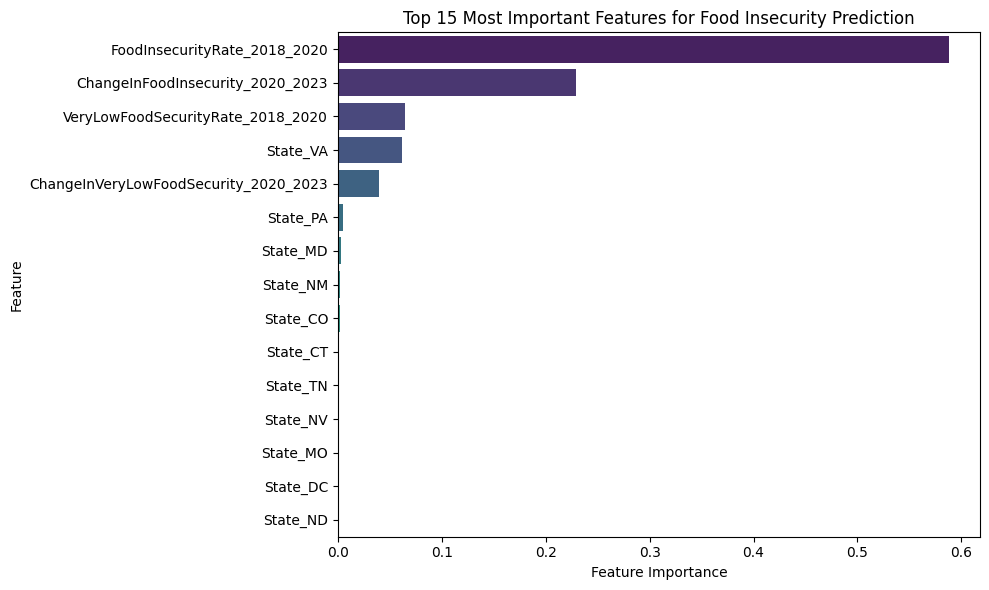

In [ ]:
# Use the final trained model and correct dataset
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Most Important Features for Food Insecurity Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


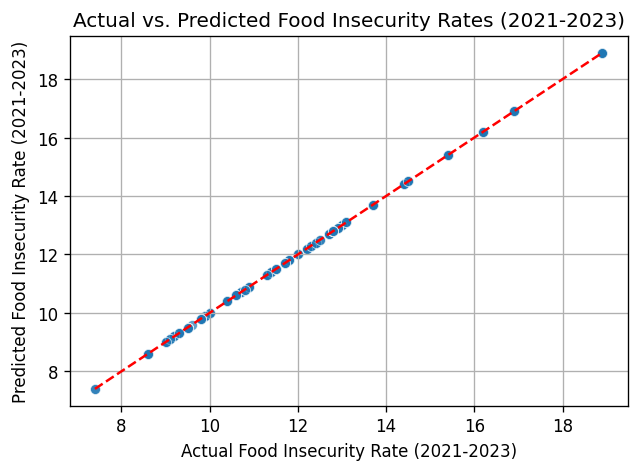

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)   # smaller canvas
sns.scatterplot(x=y_test_new, y=y_pred_corrected, alpha=0.7)
plt.title('Actual vs. Predicted Food Insecurity Rates (2021-2023)')
plt.xlabel('Actual Food Insecurity Rate (2021-2023)')
plt.ylabel('Predicted Food Insecurity Rate (2021-2023)')
plt.plot([y_test_new.min(), y_test_new.max()], [y_test_new.min(), y_test_new.max()], 'r--')
plt.grid(True)
plt.show()